In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'SimHei'

from local_utilities import load_as_df

In [5]:
stock_list = load_as_df('select * from base_stocks where market = "主板"')
stock_list = stock_list.set_index('ts_code')
code_list = list(stock_list.index)

s1,s2,s3,s4 = code_list[:500], code_list[500:1000], code_list[1000:1500], code_list[1500:]
ts_code = s1[0]

In [4]:
def trade_days(ts_code, start_day='2019-01-01'):
    df_days = load_as_df('select * from tickers where ts_code = "{}" and trade_date >= "{}"'.format(ts_code, start_day))
    return df_days

def find_spec(ts_code, start_day='2019-01-01'):
    df_days = trade_days(ts_code, start_day)
    chg_times, vol_times = 0, 0
    try:
        if df_days.shape[0] > 0:
            spec_arr = pd.qcut(np.abs(df_days.pct_chg), 10, duplicates='drop').value_counts()
            bar_chg = spec_arr.keys()[0].left
            bar_vol = pd.qcut(np.abs(df_days.vol), 10).value_counts().keys()[0].left
            chg_times, vol_times = df_days[-10:][df_days.pct_chg > bar_chg].shape[0], df_days[-10:][df_days.vol > bar_vol].shape[0]
    except Exception as e:
        print('ts_code:{}, err:{}'.format(ts_code, e))
    return (ts_code, chg_times, vol_times)

In [22]:
spec_list = []
for s in s1:
    spec_list.append(find_spec(s))

In [30]:
df_spec = pd.DataFrame(spec_list, columns=('ts_code', 'chg_times', 'vol_times'))
df_spec = df_spec.set_index('ts_code')
df_spec = df_spec[(df_spec.chg_times > 2) & (df_spec.vol_times > 1)].sort_values(by='chg_times', ascending=False)
df_spec = df_spec.join(stock_list)

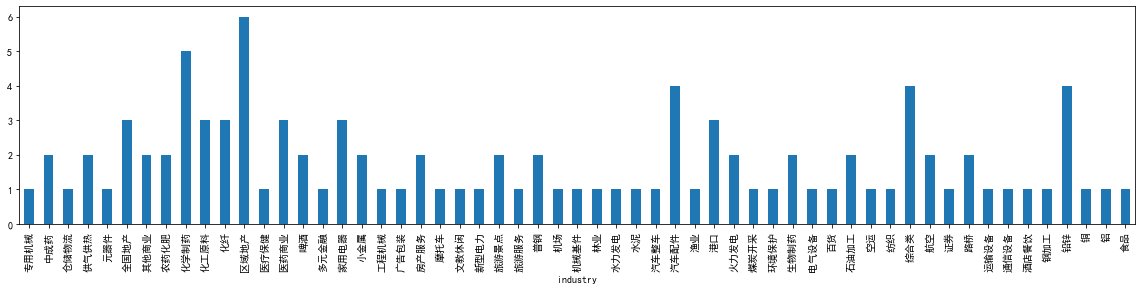

In [31]:
df_spec.groupby('industry', as_index=True).count()['symbol'].plot(kind='bar', figsize=(20,4))

In [32]:
df_all = pd.concat([df_spec,stock_list], axis=1)

Text(0, 0.5, 'price abnormal pct')

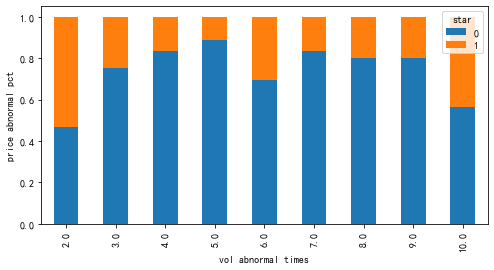

In [33]:
df_all[:4]
df_all['star'] = np.where(df_all.chg_times>5, 1, 0)
xt = pd.crosstab(df_all.vol_times, df_all.star )
xt_pct = xt.div(xt.sum(1).astype(float), axis=0)
xt_pct.plot(kind='bar', stacked=True, figsize=(8,4))
plt.xlabel('vol abnormal times')
plt.ylabel('price abnormal pct')

In [19]:
from pprint import pprint
def visual_trend(ts_code, start_day='2019-01-01'):
    tf_trend = load_as_df('select * from tickers where ts_code = "{}" and trade_date >= "{}"'.format(ts_code, start_day))
    tf_trend.set_index('trade_date')
    pprint(tf_trend.head())
    # tf_trend[:12][['close','vol']].plot(subplots=True, grid=True, layout=(2,1), figsize=(12,6))

In [21]:
visual_trend('000411.SZ')

ts_code  trade_date   open   high    low  close  pre_close  change  \
0  000411.SZ  2019-01-02  12.60  12.64  12.18  12.18      12.64   -0.46   
1  000411.SZ  2019-01-03  12.12  12.30  12.00  12.00      12.18   -0.18   
2  000411.SZ  2019-01-04  11.95  12.25  11.78  12.21      12.00    0.21   
3  000411.SZ  2019-01-07  12.20  12.46  12.13  12.44      12.21    0.23   
4  000411.SZ  2019-01-08  12.44  12.54  12.30  12.34      12.44   -0.10   

   pct_chg       vol     amount  
0  -3.6392  10641.88  13167.916  
1  -1.4778   8048.00   9772.519  
2   1.7500  11233.10  13550.574  
3   1.8837   8839.27  10909.754  
4  -0.8039   8390.80  10396.422  


In [43]:
# bins = [-np.inf, 60, 80, 100, np.inf]
# pd.cut(np.arange(1000)%100,bins=bins).value_counts()

tdays = trade_days(ts_code='000411.SZ')
tdays = tdays.set_index('trade_date')
tchgs = pd.qcut(np.abs(tdays.pct_chg), 5)

In [8]:
pd.get_dummies(tchgs)

,"(-0.001, 0.413]","(0.413, 0.845]","(0.845, 1.492]","(1.492, 2.538]","(2.538, 10.014]"
trade_date,,,,,
2019-01-02,0,0,0,0,1
2019-01-03,0,0,1,0,0
2019-01-04,0,0,0,1,0
2019-01-07,0,0,0,1,0
2019-01-08,0,1,0,0,0
...,...,...,...,...,...
2020-07-27,0,0,0,0,1
2020-07-28,0,0,0,0,1
2020-07-29,0,0,0,0,1


In [10]:
import seaborn as sb

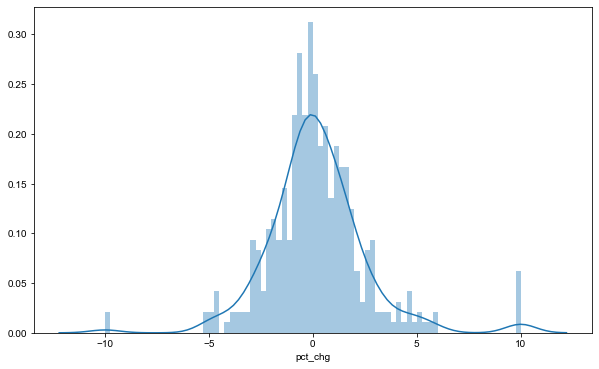

In [36]:
plt.rcParams['font.family'] = 'Arial'
plt.figure(figsize=(10,6))
sb.distplot(tdays.pct_chg, bins=80)

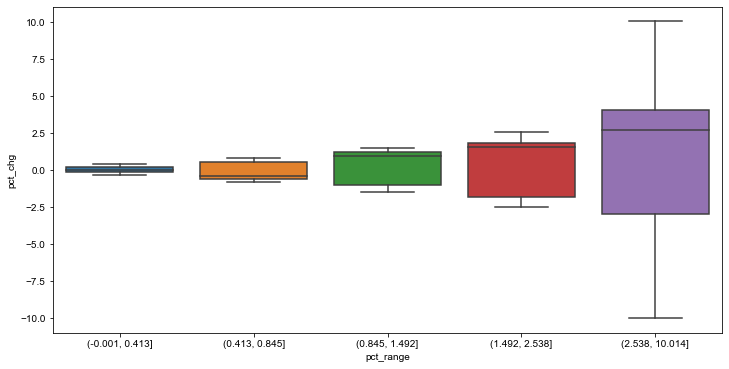

In [74]:
plt.figure(figsize=(12, 6))
p1 = tchgs.rename('pct_range')
p2 = pd.DataFrame(p1)
p3 = tdays.join(p2)
sb.boxplot(x='pct_range', y='pct_chg', data=p3)

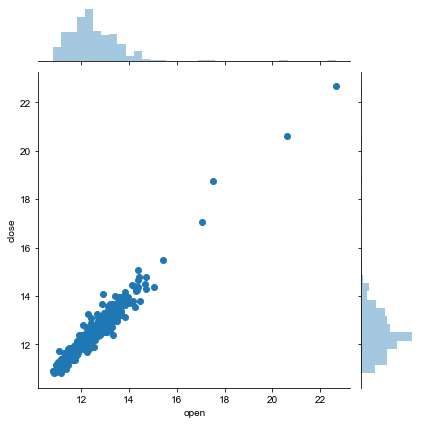

In [81]:
sb.jointplot(tdays.open, np.abs(tdays.close))

Text(0.5, 1.0, '000411')

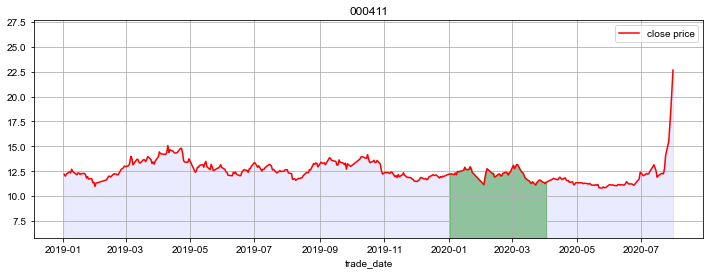

In [160]:
t1 = pd.to_datetime('2020-01-02').date()
t2 = pd.to_datetime('2020-04-02').date()

tdays.close.plot(figsize=(12,4),c='r',grid=True)
plt.fill_between(tdays.index, 0, tdays.close, color='blue', alpha=.08)
plt.fill_between(tdays[t1:t2].index, tdays[t1:t2].close, color='green', alpha=.38)

plt.ylim(np.min(tdays.close) - 5, np.max(tdays.close) + 5)
plt.legend(['close price'], loc='best')
plt.title('000411')

plt.annotate('sell for profit', xy=)

In [146]:
# tdays[(tdays.index > t1) & (tdays.index < t2)].index
tdays[t1:t2]

,ts_code,open,high,low,close,pre_close,change,pct_chg,vol,amount
trade_date,,,,,,,,,,
2019-01-02,000411.SZ,12.60,12.64,12.18,12.18,12.64,-0.46,-3.6392,10641.88,13167.916
2019-01-03,000411.SZ,12.12,12.30,12.00,12.00,12.18,-0.18,-1.4778,8048.00,9772.519
2019-01-04,000411.SZ,11.95,12.25,11.78,12.21,12.00,0.21,1.7500,11233.10,13550.574
2019-01-07,000411.SZ,12.20,12.46,12.13,12.44,12.21,0.23,1.8837,8839.27,10909.754
2019-01-08,000411.SZ,12.44,12.54,12.30,12.34,12.44,-0.10,-0.8039,8390.80,10396.422
2019-01-09,000411.SZ,12.41,13.57,12.31,12.70,12.34,0.36,2.9173,33443.61,42957.820
2019-01-10,000411.SZ,12.82,12.89,12.31,12.47,12.70,-0.23,-1.8110,16303.37,20421.575
2019-01-11,000411.SZ,12.33,12.47,12.27,12.37,12.47,-0.10,-0.8019,10475.27,12951.941
2019-01-14,000411.SZ,12.37,12.43,12.12,12.14,12.37,-0.23,-1.8593,7690.60,9416.071
